# XGBoost Steam Games Model

This notebook uses the XGBoost Classifier to predict a binary label (positive/negative) based on metadata of Steam games.

In [1]:
# imports and mounts
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.utils.class_weight import compute_class_weight


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Prep

We will load in the data cleaned from the EDA, drop the nulls, perform splitting, and assign the label based on the median score of the training set.

In [2]:
# load in data
df = pd.read_csv('/content/drive/MyDrive/DATASCI 207/DATASCI 207 Project/steam-games-cleaned_20240806.csv')
df = df.dropna(subset=['overall_review_%', 'discounted_price','awards','age_of_game', 'about_description'])
df['discounted_price'] = np.log1p(df['discounted_price'])

<ipython-input-2-79f543a4561f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['discounted_price'] = np.log1p(df['discounted_price'])


In [3]:
# separate features and label
X = df[['discounted_price',
        'awards',
        'age_of_game',
        'Action',
        'Adventure',
        'Animation & Modeling',
        'Audio Production',
        'Casual',
        'Design & Illustration',
        'Early Access',
        'Education',
        'Free to Play',
        'Game Development',
        'Indie',
        'Massively Multiplayer',
        'Movie',
        'RPG',
        'Racing',
        'Simulation',
        'Software Training',
        'Sports',
        'Strategy',
        'Utilities',
        'Video Production',
        'Web Publishing']].reset_index(drop=True)
y = df[['overall_review_%']].reset_index(drop=True)

# shuffle
np.random.seed(0)
indices = np.arange(X.shape[0])
shuffled_indices = np.random.permutation(indices)
X = X.iloc[shuffled_indices]
y = y.iloc[shuffled_indices]

In [4]:
# embedding
desc = df['about_description']

# split training and validation sets
X_train_text, X_val_test_text, X_train_num, X_test_val_num, y_train, y_val_test = train_test_split(desc, X, y, test_size=0.4, random_state=1234)

X_val_text, X_test_text, X_val_num, X_test_num, y_val, y_test = train_test_split(X_val_test_text, X_test_val_num, y_val_test, test_size=0.5, random_state=1234)

# prepare label based on train
median = y_train['overall_review_%'].median()
def make_label(df, median=median):
    df['binary_class'] = df['overall_review_%'].apply(lambda x: 1 if x > median else 0)
    return df.drop(columns=['overall_review_%'])

y_train = make_label(y_train)['binary_class']
y_val = make_label(y_val)['binary_class']
y_test = make_label(y_test)['binary_class']

In [5]:
# vectorization using TF-IDF
# tokenization and padding
# unique tokens
max_num_words = 5000
# length of sequence
max_sequence_length = 150

# initialize and fit tokenizer
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X_train_text)

X_train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_val_sequences = tokenizer.texts_to_sequences(X_val_text)
X_test_sequences = tokenizer.texts_to_sequences(X_test_text)

# pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=max_num_words)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_val_tfidf = tfidf_vectorizer.transform(X_val_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text).toarray()

# scale data
scaler = StandardScaler()
X_train_num[['discounted_price', 'awards', 'age_of_game']] = scaler.fit_transform(X_train_num[['discounted_price', 'awards', 'age_of_game']])
X_val_num[['discounted_price', 'awards', 'age_of_game']] = scaler.transform(X_val_num[['discounted_price', 'awards', 'age_of_game']])
X_test_num[['discounted_price', 'awards', 'age_of_game']] = scaler.transform(X_test_num[['discounted_price', 'awards', 'age_of_game']])

# add to features
X_train = np.hstack([X_train_tfidf, X_train_padded, X_train_num])
X_val = np.hstack([X_val_tfidf, X_val_padded, X_val_num])
X_test = np.hstack([X_test_tfidf, X_test_padded, X_test_num])

# Model Building and Fitting

Create a model using XGBClassifier, evaluate with AUC and error.

In [6]:
def build_model(X, Y, X_val, y_val, learning_rate=0.1, n_estimators=100, max_depth=6, subsample=0.5, min_child_weight=1, colsample_bytree=0.5, eval_metric=["auc","error"], early_stopping_rounds=10, gamma=0, verbose=True):
    '''create an xgboost classifier model and fit
    returns a model which can be used to predict
    X: features
    Y: labels
    X_val: validation features
    y_val: validation labels
    learning_rate: default 0.1
    n_estimators: default 100
    max_depth: default 6
    subsample: default 0.5
    min_child_weight: default 1
    colsample_bytree: default 0.5
    eval_metric: default ["auc","error"]
    early_stopping_rounds: default 10
    verbose: default True
    '''

    class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
    scale_pos_weight = class_weights[1] / class_weights[0]

    xgb_classifier = XGBClassifier(objective='binary:logistic',
                                   eval_metric=eval_metric,
                                   early_stopping_rounds=early_stopping_rounds,
                                   learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   subsample=subsample,
                                   min_child_weight=min_child_weight,
                                   colsample_bytree=colsample_bytree,
                                   scale_pos_weight=scale_pos_weight,
                                   gamma=gamma)

    # fit the model
    model = xgb_classifier.fit(X, Y, eval_set=[(X_val, y_val)], verbose=verbose)
    return model

# Hyperparameter Tuning

We will prepare the model and then use Random Search to search for ideal hyperparameters. Starting with the Random Search results, continue to tweak hyperparameters for any improvements.

In [7]:
# use function to build model
model = build_model(X_train, y_train, X_val, y_val, verbose=0)

In [21]:
# search parameters
params = {
    'gamma': [0.5, 0.8, 1, 1.2],
    'learning_rate': [0.05, 0.08, 0.1, 1.2],
    'n_estimators': [100, 120, 150, 180],
    'max_depth': [4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [2, 3, 4],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8]
}

In [22]:
# randoms search for hyperparameters
random_search = RandomizedSearchCV(model, params, n_iter=50, scoring='accuracy', cv=3, verbose=False, random_state=42, n_jobs=-1)

# fit search
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# print
results = pd.DataFrame(random_search.cv_results_)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)
results

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[0]	validation_0-auc:0.61949	validation_0-error:0.40971
[1]	validation_0-auc:0.64137	validation_0-error:0.39805
[2]	validation_0-auc:0.64870	validation_0-error:0.39450
[3]	validation_0-auc:0.65203	validation_0-error:0.38752
[4]	validation_0-auc:0.65140	validation_0-error:0.39044
[5]	validation_0-auc:0.65164	validation_0-error:0.39221
[6]	validation_0-auc:0.65183	validation_0-error:0.39044
[7]	validation_0-auc:0.65316	validation_0-error:0.39019
[8]	validation_0-auc:0.65236	validation_0-error:0.39247
[9]	validation_0-auc:0.65356	validation_0-error:0.39031
[10]	validation_0-auc:0.65442	validation_0-error:0.38892
[11]	validation_0-auc:0.65639	validation_0-error:0.38828
[12]	validation_0-auc:0.65676	validation_0-error:0.38765
[13]	validation_0-auc:0.65809	validation_0-error:0.38778
Best parameters: {'subsample': 0.9, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.6}
Best score: 0.620213035759574


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,126.955475,14.679013,0.262312,0.002912,0.8,120,3,7,0.08,0.8,0.7,"{'subsample': 0.8, 'n_estimators': 120, 'min_c...",0.615775,0.611844,0.615902,0.614507,0.001884,16
1,108.147972,13.638971,0.271486,0.017639,0.6,180,4,5,0.05,0.8,0.5,"{'subsample': 0.6, 'n_estimators': 180, 'min_c...",0.617804,0.607913,0.609434,0.611717,0.004349,31
2,79.584112,17.537811,0.259873,0.017484,0.8,180,2,4,0.05,1.2,0.6,"{'subsample': 0.8, 'n_estimators': 180, 'min_c...",0.609308,0.608166,0.607532,0.608335,0.000735,38
3,62.442506,4.458463,0.264164,0.014780,0.9,120,2,4,1.2,1,0.6,"{'subsample': 0.9, 'n_estimators': 120, 'min_c...",0.600431,0.602206,0.612351,0.604996,0.005251,41
4,123.337867,16.902204,0.240825,0.044129,0.6,180,2,5,0.1,1.2,0.8,"{'subsample': 0.6, 'n_estimators': 180, 'min_c...",0.612731,0.612097,0.613999,0.612943,0.000791,24
5,115.072242,6.068404,0.284654,0.016605,0.6,120,2,7,0.1,1,0.8,"{'subsample': 0.6, 'n_estimators': 120, 'min_c...",0.617043,0.613619,0.614634,0.615098,0.001436,11
6,141.791324,9.164566,0.246506,0.035450,0.8,120,3,7,0.08,1.2,0.6,"{'subsample': 0.8, 'n_estimators': 120, 'min_c...",0.620213,0.611337,0.615014,0.615521,0.003642,10
7,93.563606,8.927292,0.265696,0.004247,0.7,150,3,6,0.05,0.5,0.7,"{'subsample': 0.7, 'n_estimators': 150, 'min_c...",0.619199,0.604489,0.609942,0.611210,0.006072,32
8,146.676862,36.243875,0.235609,0.060096,0.8,100,4,5,0.1,0.5,0.5,"{'subsample': 0.8, 'n_estimators': 100, 'min_c...",0.618184,0.611463,0.622115,0.617254,0.004398,6
9,62.575411,3.272927,0.249821,0.001019,0.8,150,2,4,1.2,0.8,0.6,"{'subsample': 0.8, 'n_estimators': 150, 'min_c...",0.602587,0.599163,0.606771,0.602840,0.003111,42


Starting Parameters:
```
learning_rate=0.1,
n_estimators=150,
max_depth=5,
early_stopping_rounds=20,
subsample=0.9,
min_child_weight=2,
colsample_bytree=0.6,
gamma=1
```
Validation Results:
```
AUC:0.66055
Error:0.38701
Accuracy: 61.51%
```

Change | AUC | Error | Accuracy
-|-|-|-
learning_rate=0.08 | 0.65990 | 0.38714 | 61.64%
n_estimators=120, subsample=0.9|0.66074|0.38372|61.84%
n_estimators=120, subsample=0.9, gamma=2|0.66109|0.38511|61.88%
n_estimators=120, subsample=0.9, gamma=2|0.66109|0.38511|61.88%

In [8]:
model = build_model(X_train, y_train,
                    X_val, y_val,
                    learning_rate=0.1,
                    n_estimators=120,
                    max_depth=5,
                    early_stopping_rounds=20,
                    subsample=0.9,
                    min_child_weight=3,
                    colsample_bytree=0.7,
                    gamma=2,
                    verbose=121)

[0]	validation_0-auc:0.61943	validation_0-error:0.40946
[48]	validation_0-auc:0.66142	validation_0-error:0.38625


In [9]:
# print accuracies
def accuracy(model, X, Y):
  acc = model.score(X,Y)
  print("Accuracy: %.2f%%" % (acc * 100.0))

accuracy(model, X_train, y_train)
accuracy(model, X_val, y_val)
accuracy(model, X_test, y_test)

Accuracy: 65.38%
Accuracy: 61.77%
Accuracy: 62.65%


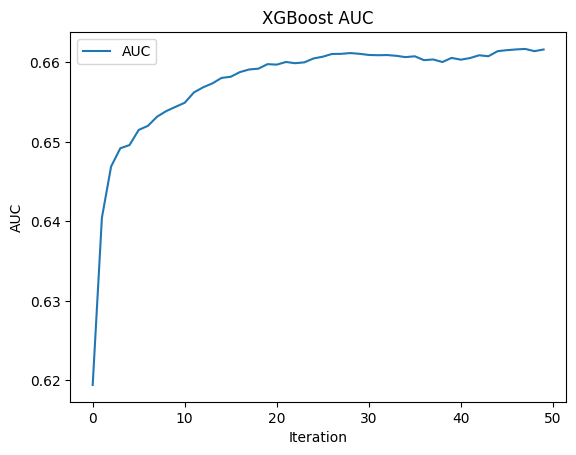

In [10]:
# plot AUC for training set
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='AUC')
ax.legend()
plt.ylabel('AUC')
plt.xlabel('Iteration')
plt.title('XGBoost AUC')
plt.show()

# Model Predictions for Test Set

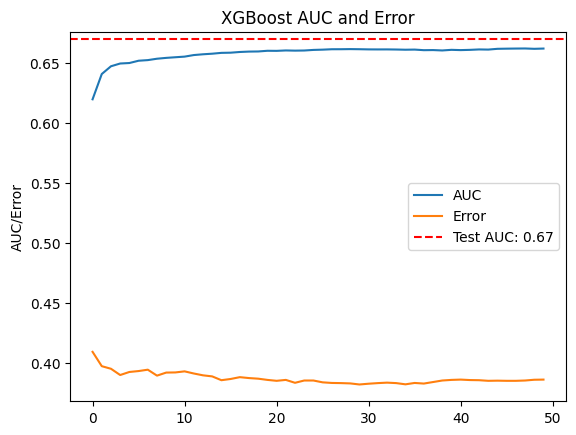

Test AUC: 0.67


In [11]:
# Compute AUC score
y_test_proba = model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)


# Get evaluation results
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# Plot training and validation AUC
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='AUC')
ax.plot(x_axis, results['validation_0']['error'], label='Error')
ax.legend()
plt.ylabel('AUC/Error')
plt.title('XGBoost AUC and Error')

# Add test AUC to the plot
plt.axhline(y=test_auc, color='r', linestyle='--', label=f'Test AUC: {test_auc:.2f}')
plt.legend()
plt.show()

print(f'Test AUC: {test_auc:.2f}')

In [13]:
# evaluate: log loss, ROC AUC
def eval_loss_auc(model, X, Y):
    '''
    evaluate model using log loss and ROC AUC
    model: model to evaluate
    X: features
    Y: labels
    '''
    y_pred_proba = model.predict_proba(X)
    print('Log loss: ',log_loss(Y, y_pred_proba))
    roc_auc = roc_auc_score(Y, y_pred_proba[:,1])
    print('AUC: ', roc_auc)
    return log_loss(Y, y_pred_proba), roc_auc

eval_loss_auc(model, X_test, y_test)

Log loss:  0.6484946623191941
AUC:  0.6705290201280053


(0.6484946623191941, 0.6705290201280053)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

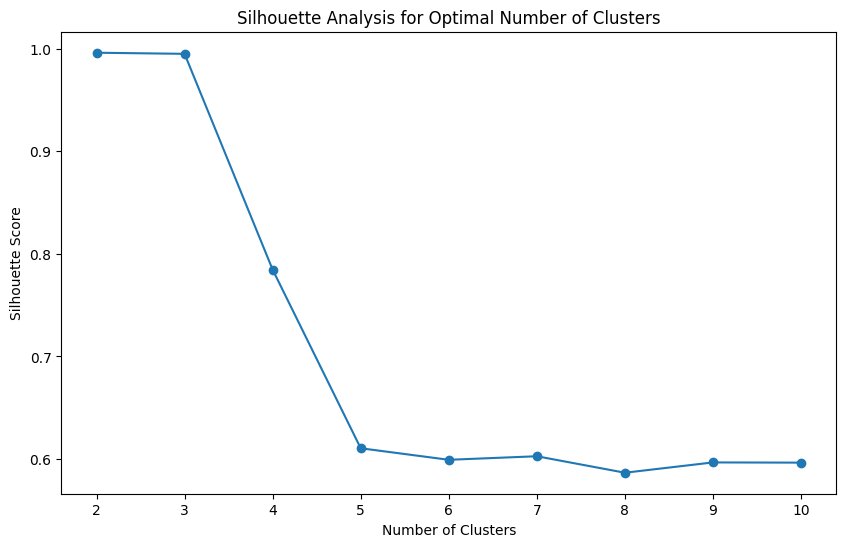

In [ ]:
from sklearn.metrics import silhouette_score
# Define the range for the number of clusters
range_n_clusters = list(range(2, 11))

# Calculate silhouette scores for each number of clusters
silhouette_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

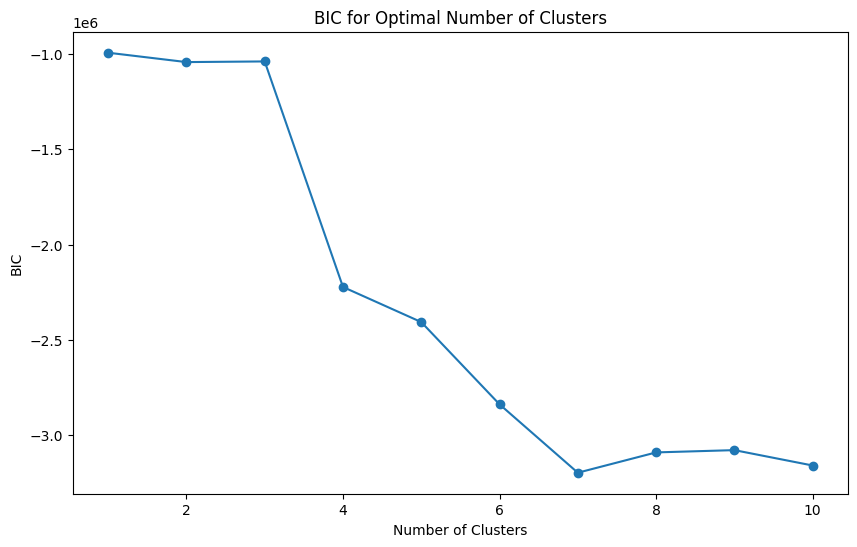

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Define the range for the number of clusters
range_n_clusters = list(range(1, 11))

# Calculate BIC for each number of clusters
bics = []
for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters, random_state=10)
    gmm.fit(X_train)
    bics.append(gmm.bic(X_train))

# Plot the BIC against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, bics, marker='o')
plt.title('BIC for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.show()


In [ ]:
n_clusters = 9
random_state = 10

# define KMeans model
def fit_kmeans(X, n_clusters, random_state):
  kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
  model = kmeans.fit(X)
  return model

# fit KMeans model
kmeans = fit_kmeans(X_train[['discounted_price','awards', 'age_of_game']], n_clusters, random_state)

# get cluster predictions
pred_cluster = kmeans.predict(X_train[['discounted_price','awards', 'age_of_game']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
X_cluster = X_train.copy()
X_cluster['cluster'] = pred_cluster
X_cluster.head()

,discounted_price,awards,age_of_game,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,...,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing,cluster
31494,53.0,0,6.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
22976,96.0,0,5.0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,4
15643,52.0,0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
35052,0.0,0,6.0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,4
7596,565.0,1,7.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


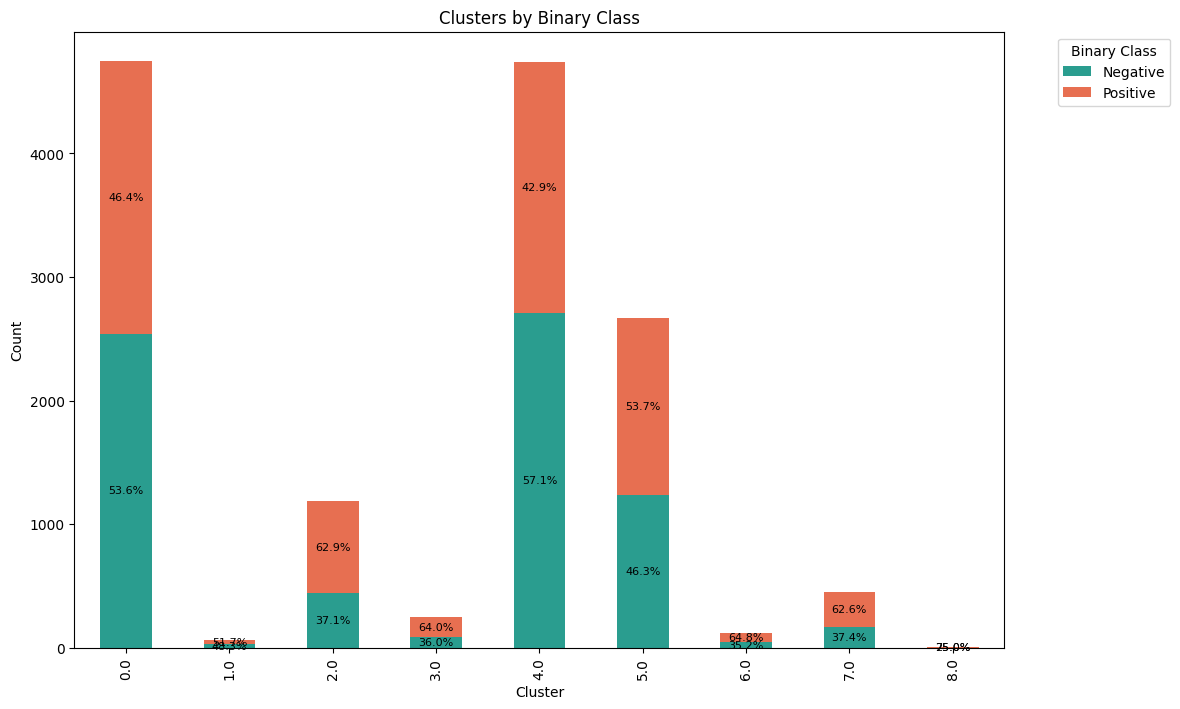

,count
cluster,
0.0,7863
1.0,89
2.0,1990
3.0,396
4.0,7963
5.0,4435
6.0,182
7.0,739
8.0,4


In [ ]:
clusters = pd.concat([X_cluster, y_train], axis=1)
cluster_counts = clusters.groupby(['cluster', 'binary_class']).size().unstack(fill_value=0)

# Create a DataFrame with counts for each cluster and binary_class
cluster_data = cluster_counts.reset_index()
# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each binary class
colors = ['#2a9d8f', '#e76f51']  # Change these colors as needed

# Plot each binary class
cluster_data.set_index('cluster').plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding labels and title
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Clusters by Binary Class')
plt.xticks(rotation=90)
# plt.yscale('log')

# Add percentage labels to the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()

    # Calculate total height of the stack
    total_height = sum(patch.get_height() for patch in ax.patches if patch.get_x() == x)

    # Calculate the percentage
    percentage = (height / total_height) * 100

    # Add label if percentage is greater than 10%
    if percentage > 10:
        ax.text(x + width / 2., y + height/2, f'{percentage:.1f}%',
                ha='center', va='center', fontsize=8, color='black')


# Adding legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Negative', 'Positive'], title='Binary Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()
clusters['cluster'].value_counts().sort_index()

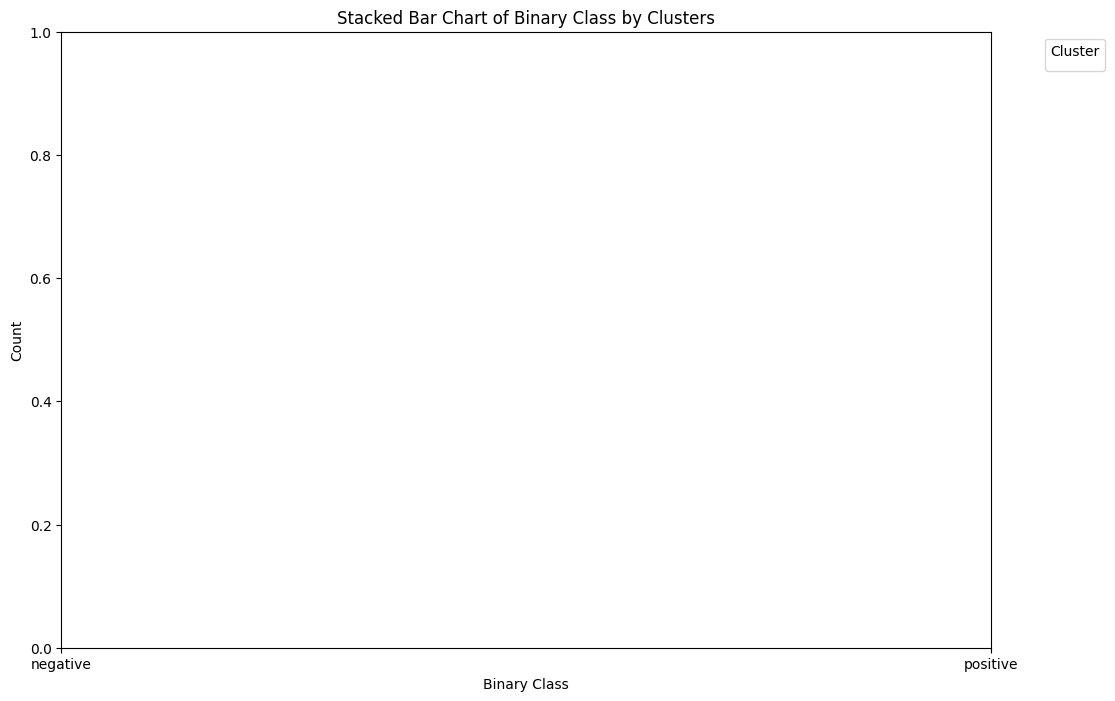

In [ ]:
cluster_counts = clusters.groupby(['binary_class', 'cluster']).size().unstack(fill_value=0)
cluster_data = cluster_counts.reset_index()
# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define a color palette for clusters
colors = plt.get_cmap('tab10').colors  # Using tab10 color palette for up to 10 clusters

# Calculate total counts for each binary class
total_counts = cluster_data.sum(axis=1)

# Plot each cluster
bottom = [0] * len(cluster_data)
for cluster in cluster_counts.columns:
    heights = cluster_data[cluster]
    ax.bar(cluster_data['binary_class'], heights, bottom=bottom, label=f'Cluster {cluster}', color=colors[cluster % len(colors)])

    # Add percentage labels if percentage is over 10%
    for i in range(len(cluster_data)):
        percentage = (heights[i] / total_counts[i]) * 100
        if percentage > 2:
            ax.text(cluster_data['binary_class'][i], bottom[i] + heights[i] / 2, f'{percentage:.1f}%',
                    ha='center', va='center', fontsize=10, color='black')

    bottom = [sum(x) for x in zip(bottom, heights)]

# Adding labels and title
plt.xlabel('Binary Class')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Binary Class by Clusters')
plt.xticks([0, 1], ['negative', 'positive'])  # Ensuring the x-axis shows 0 and 1

# Adding legend
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

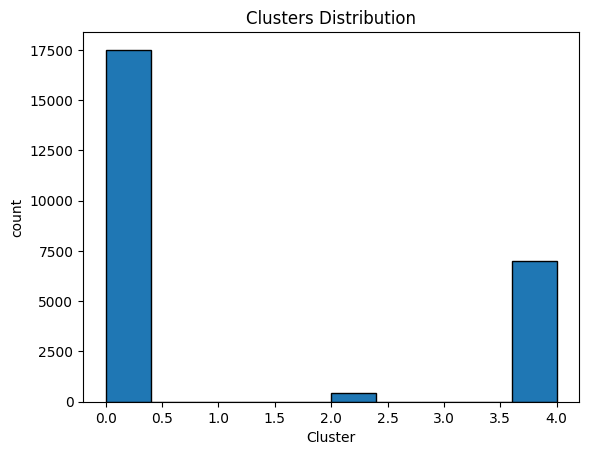

cluster
0    17511
4     7015
2      420
1        2
3        1
Name: count, dtype: int64


In [ ]:
# dist of value counts in clusters
plt.hist(X_cluster['cluster'], bins=10, edgecolor='black')
plt.title('Clusters Distribution')
plt.xlabel('Cluster')
plt.ylabel('count')
plt.show()
print(X_cluster['cluster'].value_counts())

In [ ]:
cluster_stats = X_cluster.groupby('cluster').agg(['mean','std', 'median'])
cluster_stats

discounted_price                           awards                   \
                    mean          std    median      mean       std median   
cluster                                                                      
0              42.262651    45.321225      39.0  0.110361  0.658525    0.0   
1           81000.000000  1414.213562   81000.0  0.000000  0.000000    0.0   
2            1857.324597   336.856025    1799.0  0.669355  2.378258    0.0   
3          150000.000000          NaN  150000.0  0.000000       NaN    0.0   
4             527.806314    95.002570     489.0  0.554307  1.812728    0.0   
5            7297.769231   962.759156    7900.0  0.000000  0.000000    0.0   
6            3449.435065   625.437415    3331.0  0.538961  1.551441    0.0   
7             986.838135   175.506334     880.0  0.708748  1.821440    0.0   
8             260.927820    69.735724     250.0  0.245127  1.072863    0.0   
9           16500.000000     0.000000   16500.0  0.000000  0.000000    0.0   

        age_of_game                     Action  ... Strategy Utilities  \
               mean       std median      mean  ...   median      mean   
cluster                                         ...                      
0          4.312771  2.794139    4.0  0.419518  ...      0.0  0.000120   
1          3.000000  2.828427    3.0  0.500000  ...      0.0  0.000000   
2          3.653226  3.385756    3.0  0.518145  ...      0.0  0.000000   
3          4.000000       NaN    4.0  0.000000  ...      0.0  0.000000   
4          4.342251  3.429017    4.0  0.457464  ...      0.0  0.000000   
5          2.846154  2.544476    1.0  0.384615  ...      0.0  0.000000   
6          3.006494  2.749918    2.0  0.610390  ...      0.0  0.000000   
7          3.666317  3.381449    3.0  0.411734  ...      0.0  0.000524   
8          5.223627  3.627011    5.0  0.408860  ...      0.0  0.000118   
9          1.500000  0.707107    1.5  0.000000  ...      0.0  0.000000   

                         Video Production             Web Publishing  \
              std median             mean  std median           mean   
cluster                                                                
0        0.010976    0.0              0.0  0.0    0.0        0.00012   
1        0.000000    0.0              0.0  0.0    0.0        0.00000   
2        0.000000    0.0              0.0  0.0    0.0        0.00000   
3             NaN    0.0              0.0  NaN    0.0        0.00000   
4        0.000000    0.0              0.0  0.0    0.0        0.00000   
5        0.000000    0.0              0.0  0.0    0.0        0.00000   
6        0.000000    0.0              0.0  0.0    0.0        0.00000   
7        0.022887    0.0              0.0  0.0    0.0        0.00000   
8        0.010869    0.0              0.0  0.0    0.0        0.00000   
9        0.000000    0.0              0.0  0.0    0.0        0.00000   

                          
              std median  
cluster                   
0        0.010976    0.0  
1        0.000000    0.0  
2        0.000000    0.0  
3             NaN    0.0  
4        0.000000    0.0  
5        0.000000    0.0  
6        0.000000    0.0  
7        0.000000    0.0  
8        0.000000    0.0  
9        0.000000    0.0  

[10 rows x 75 columns]

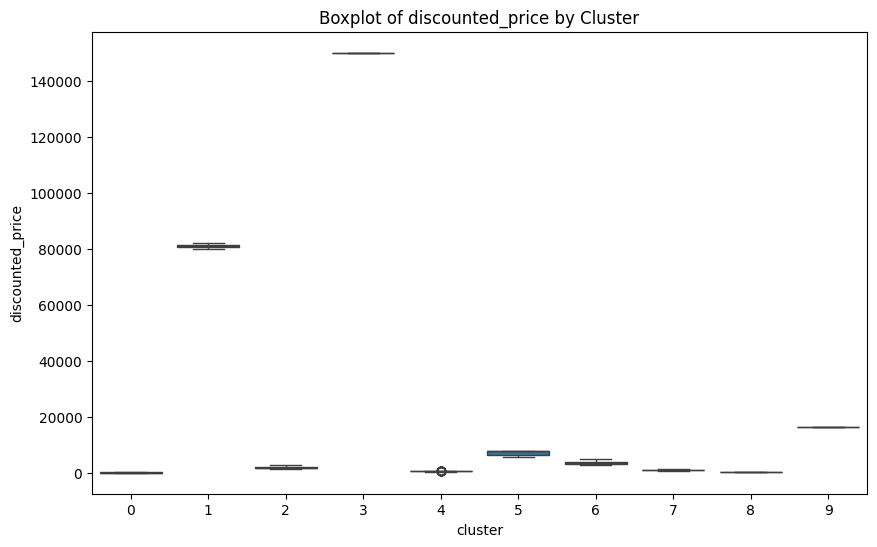

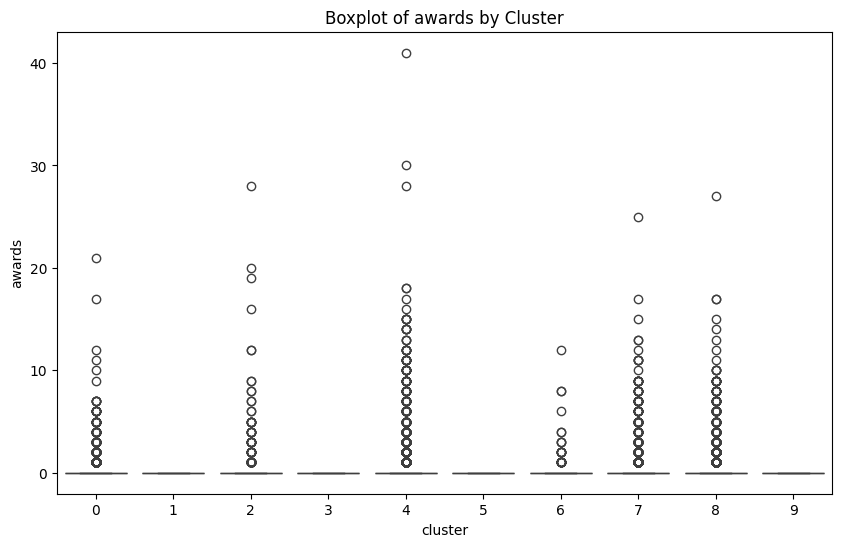

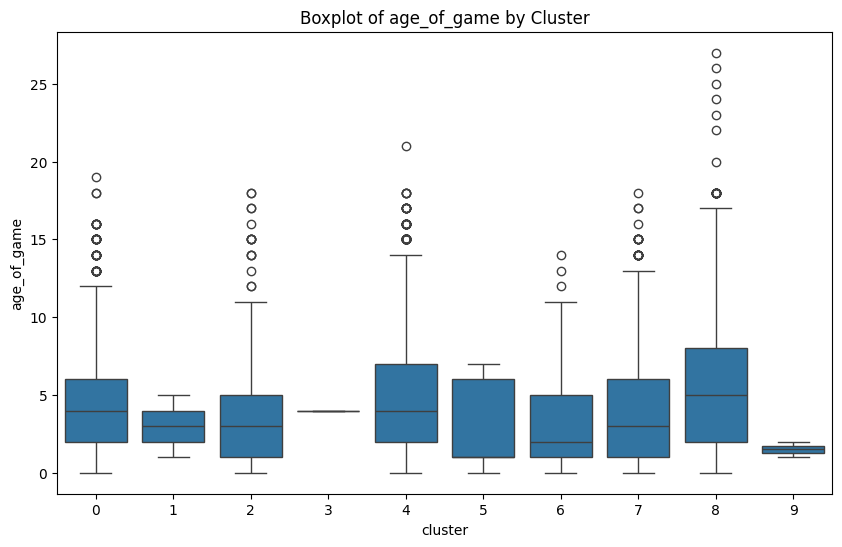

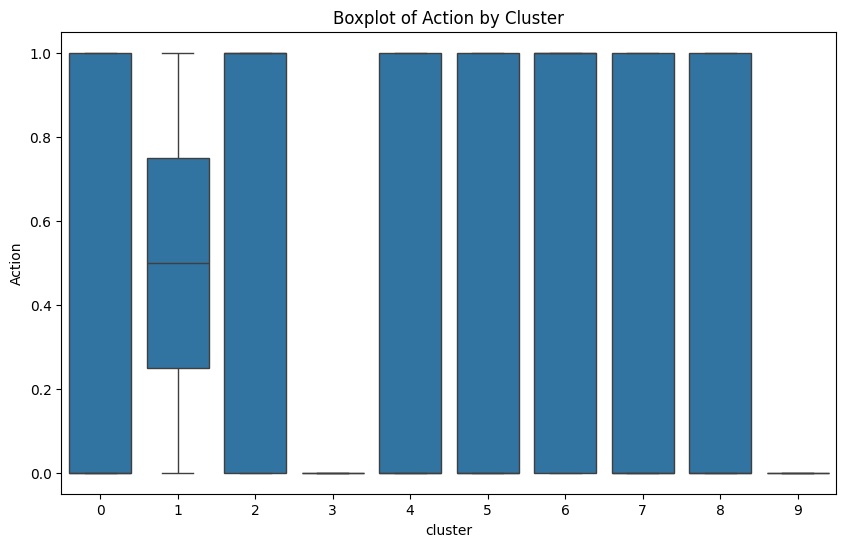

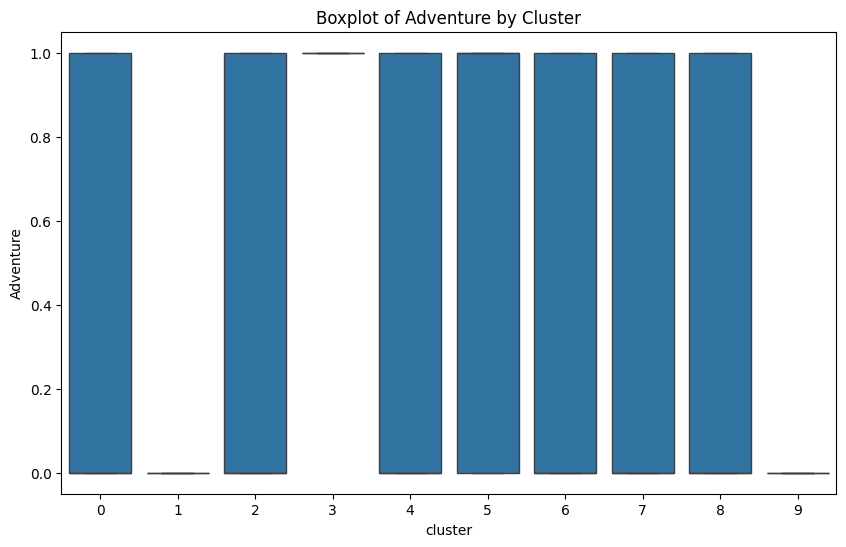

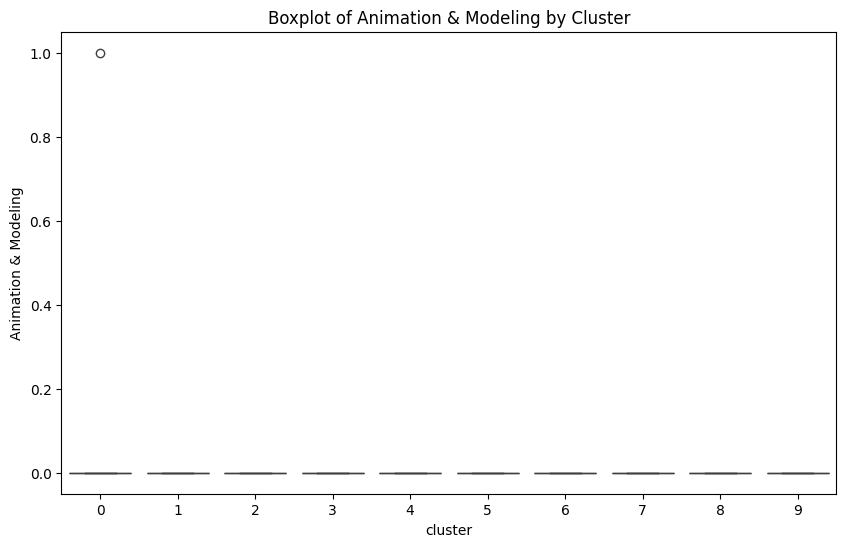

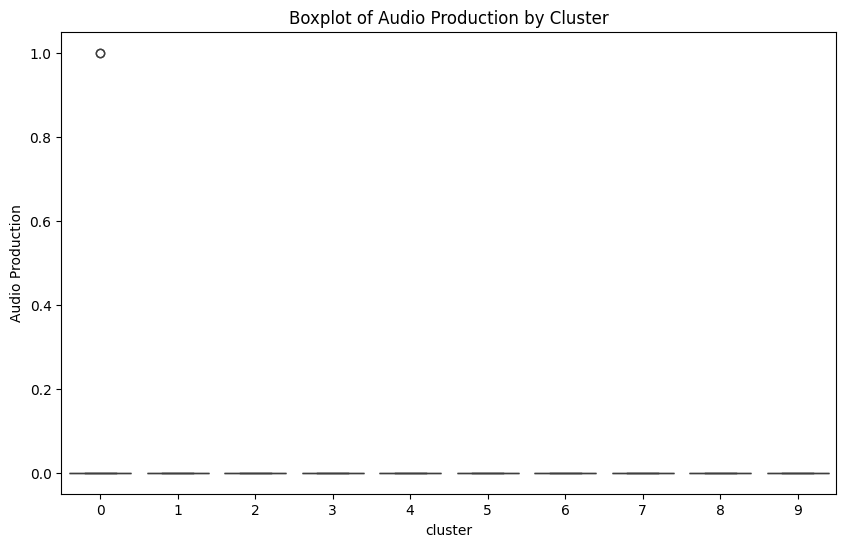

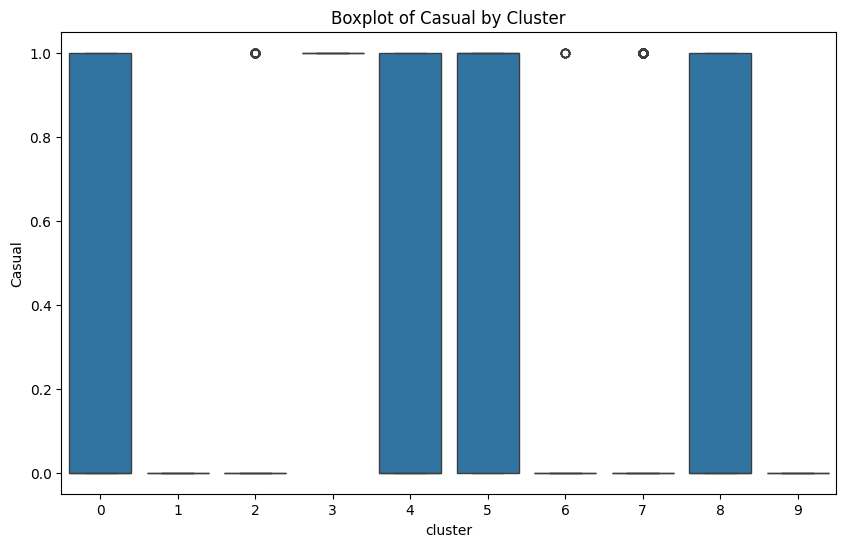

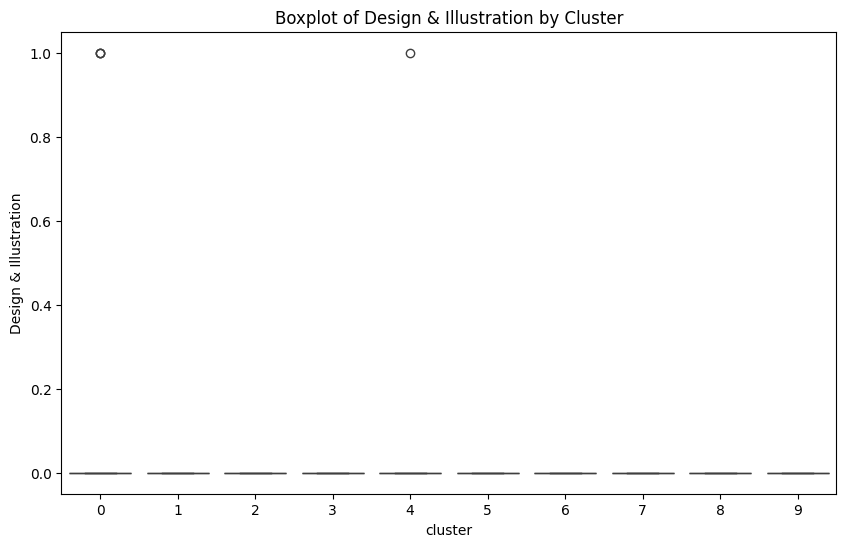

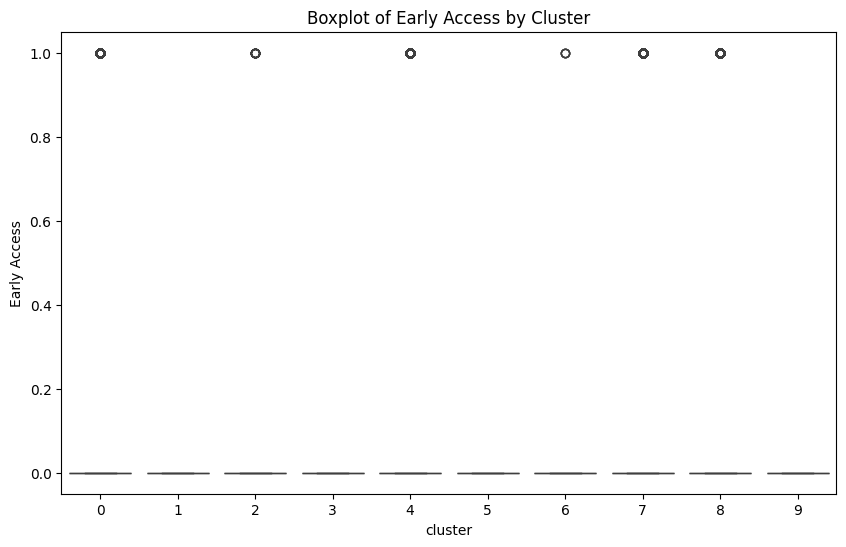

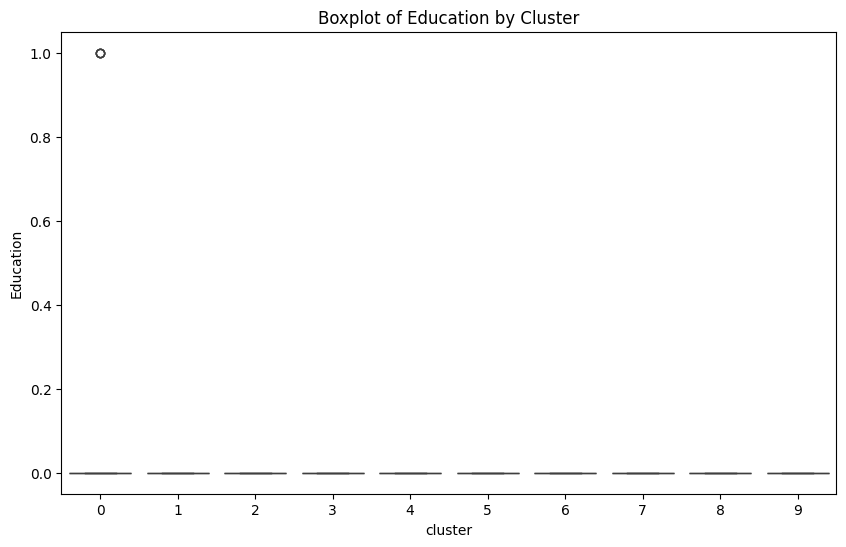

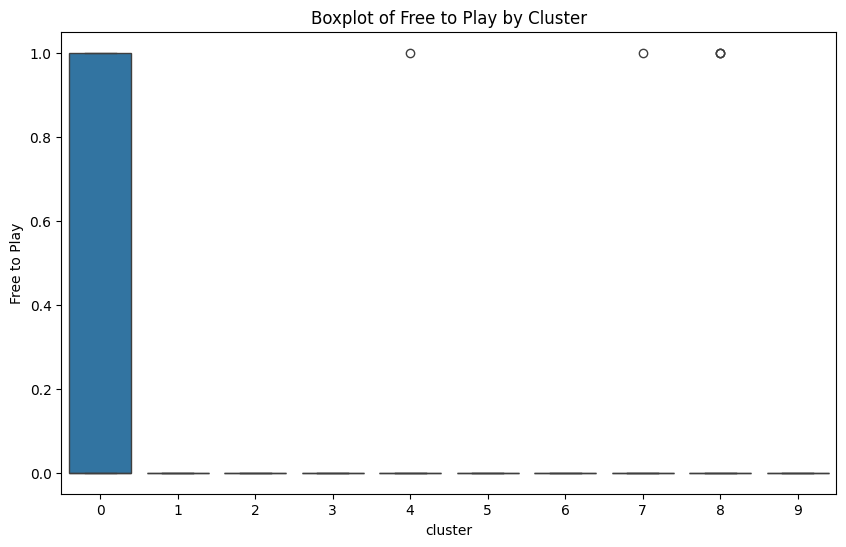

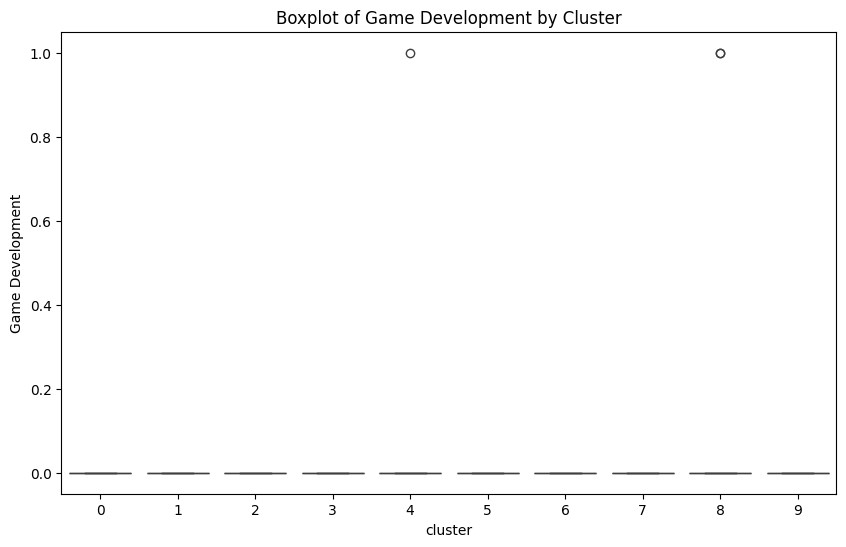

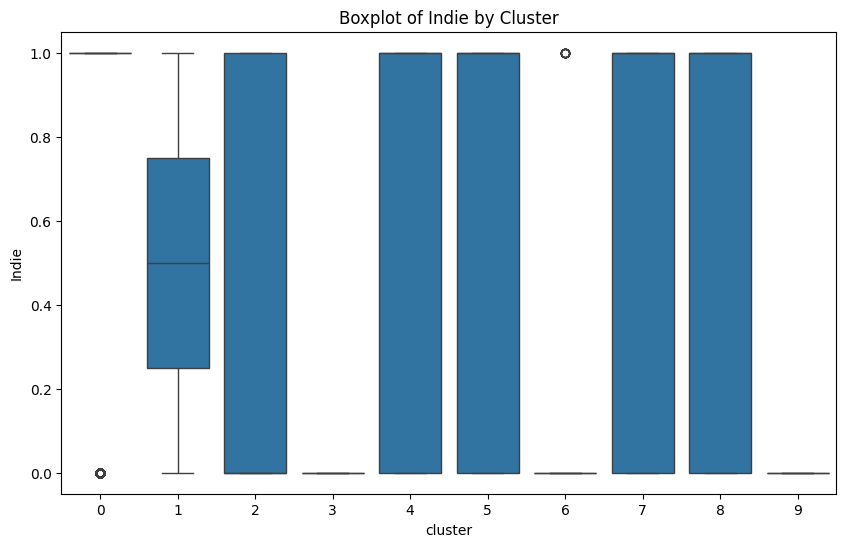

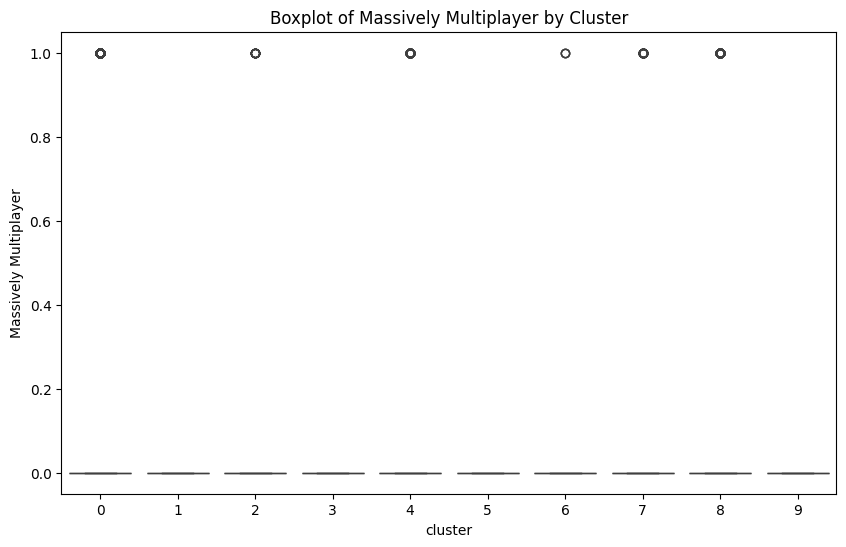

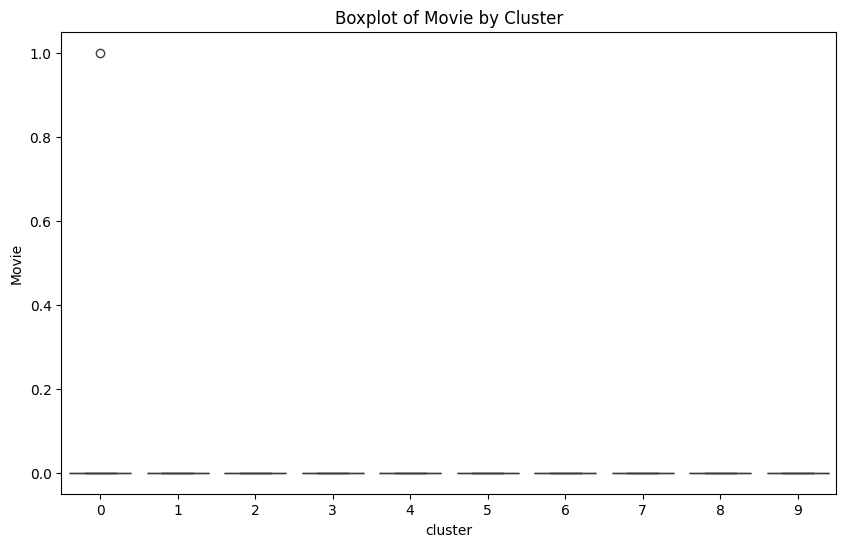

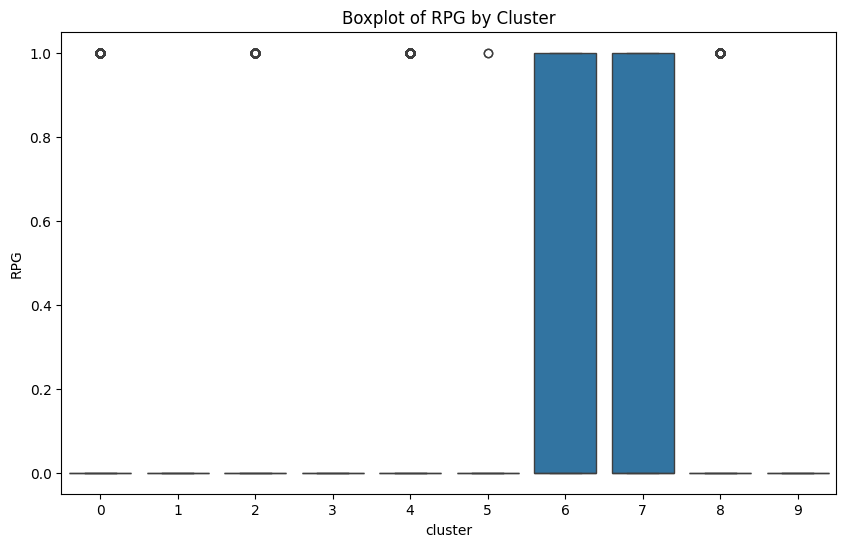

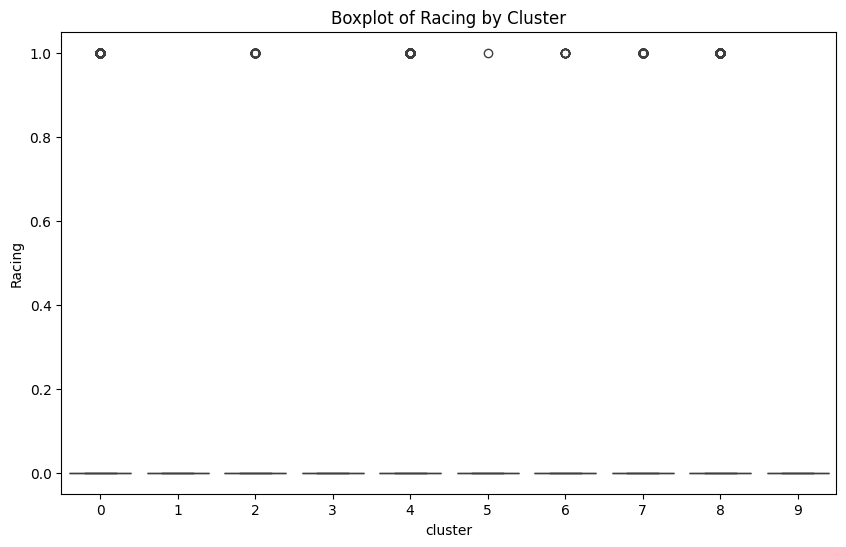

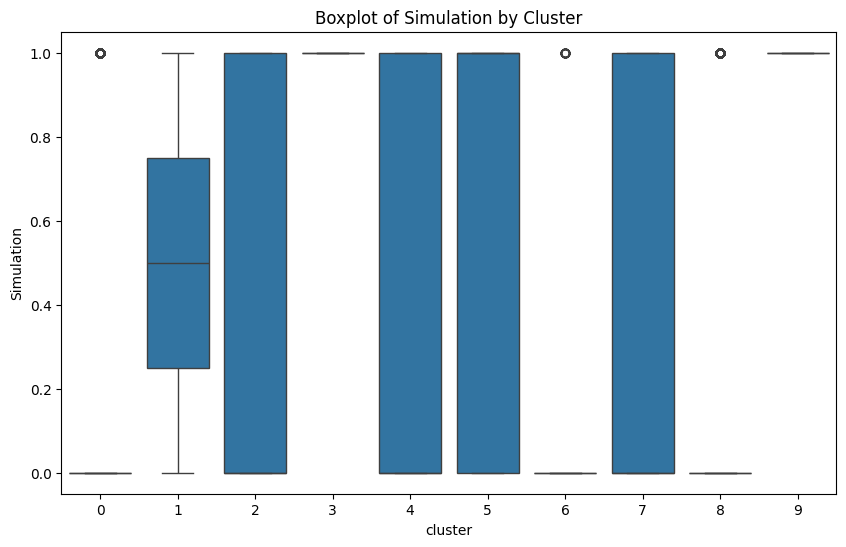

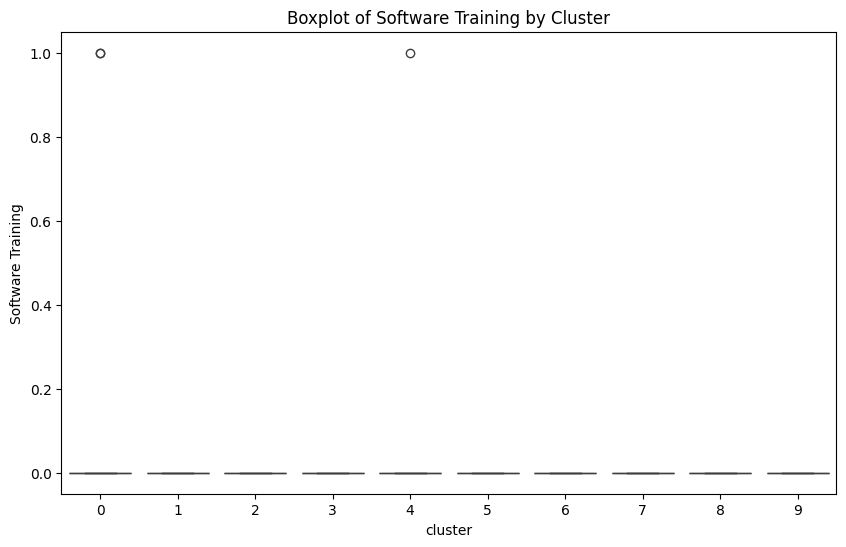

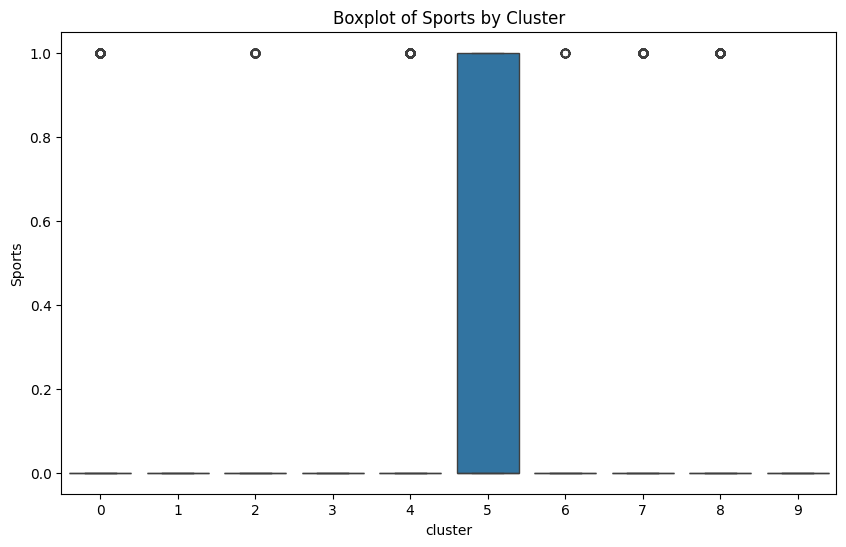

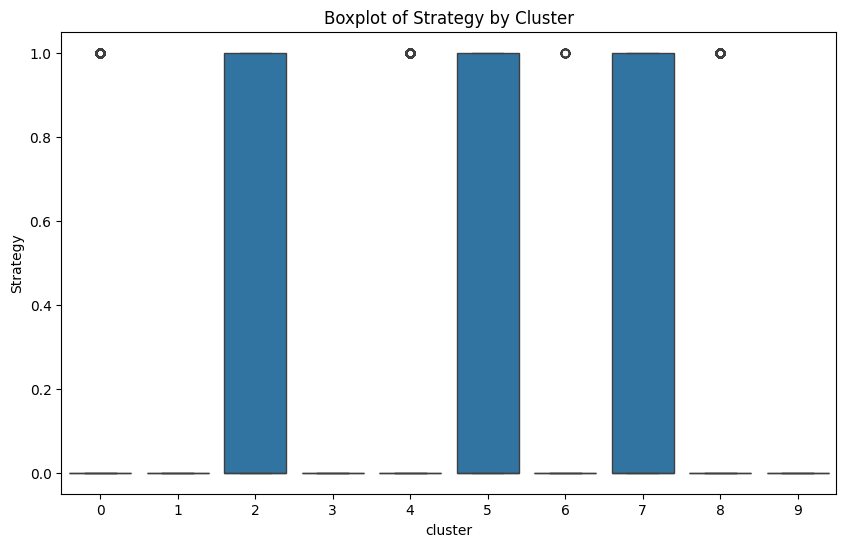

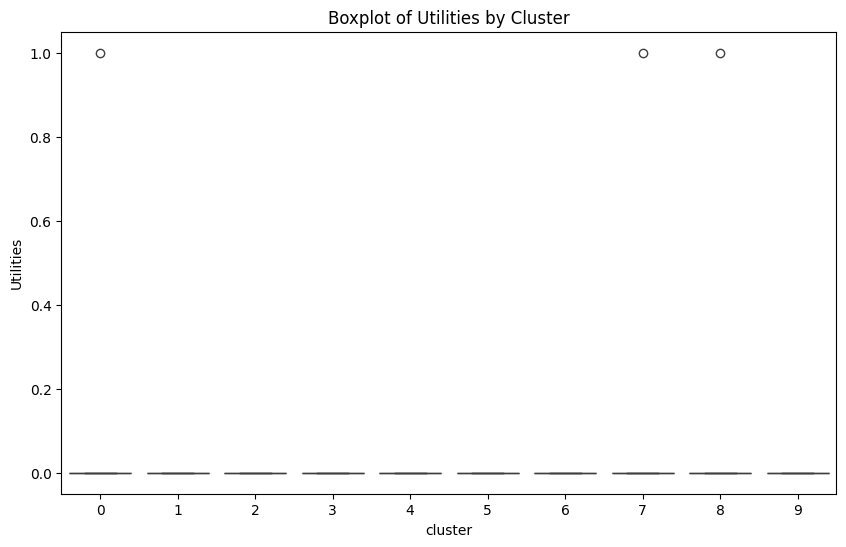

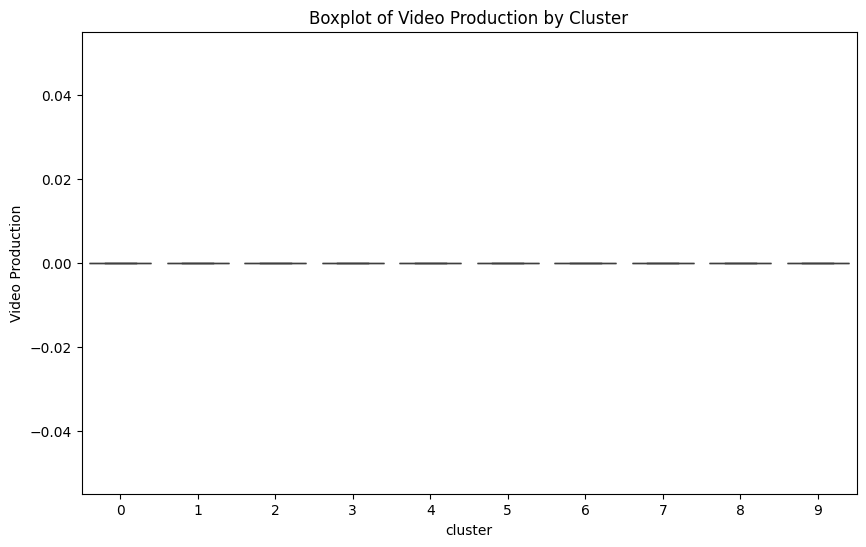

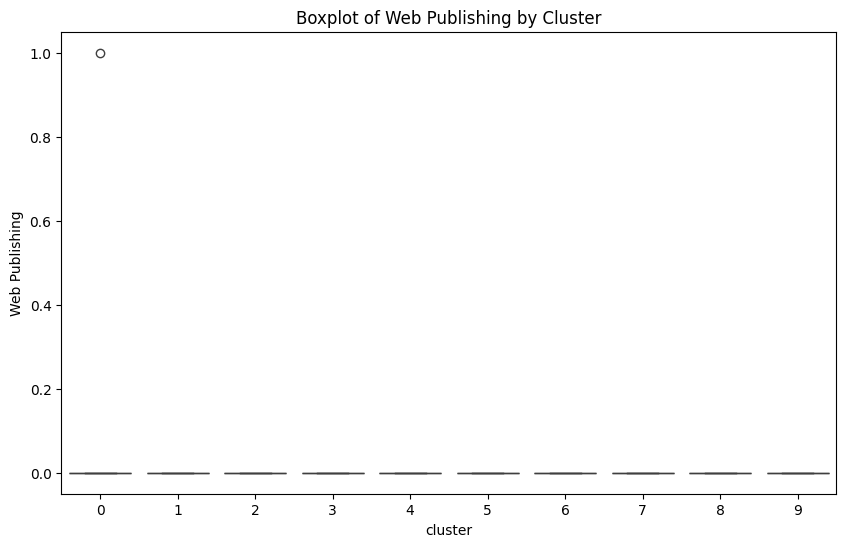

In [ ]:
# box plots
for column in X_cluster.columns.drop('cluster'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=column, data=X_cluster)
    plt.title(f'Boxplot of {column} by Cluster')
    plt.show()

In [ ]:
## PCA
# standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_cluster.drop(columns=['cluster']))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
X_cluster['pca1'] = pca_result[:, 0]
X_cluster['pca2'] = pca_result[:, 1]

# Plot PCA results
fig = px.scatter(
    X_cluster, x='pca1', y='pca2', color='cluster',
    title='PCA Result by Cluster',
    labels={'pca1': 'PCA Component 1', 'pca2': 'PCA Component 2'},
    color_continuous_scale=px.colors.qualitative.Set1
)

fig.show()

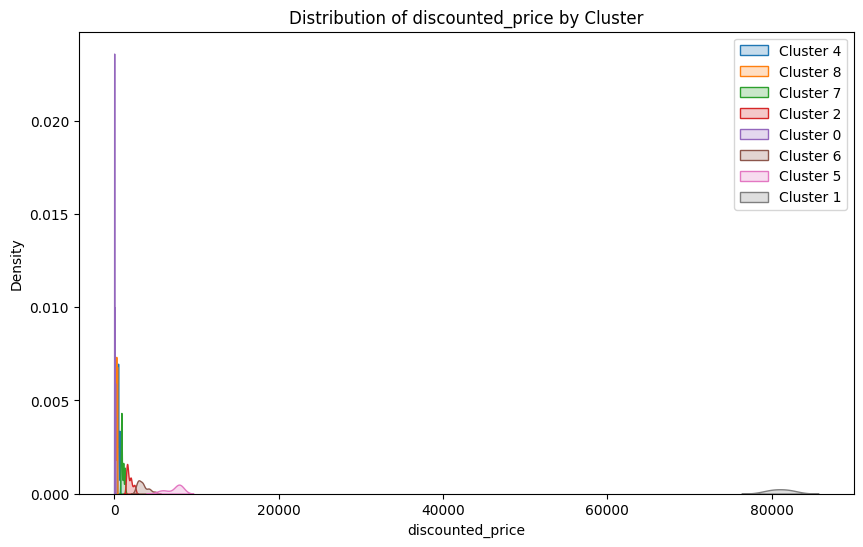

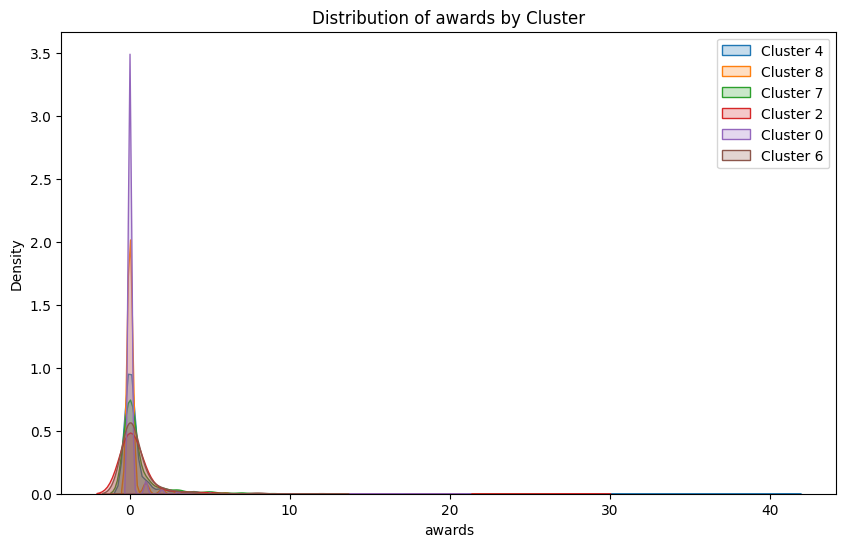

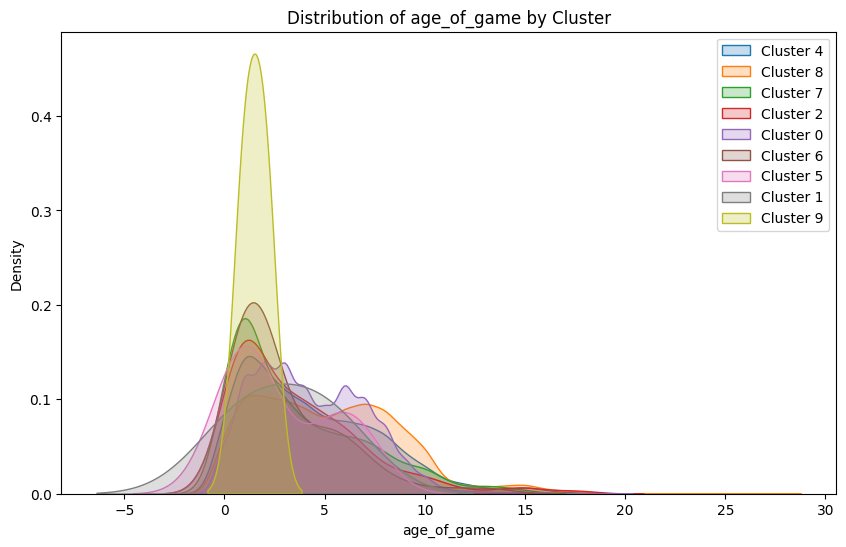

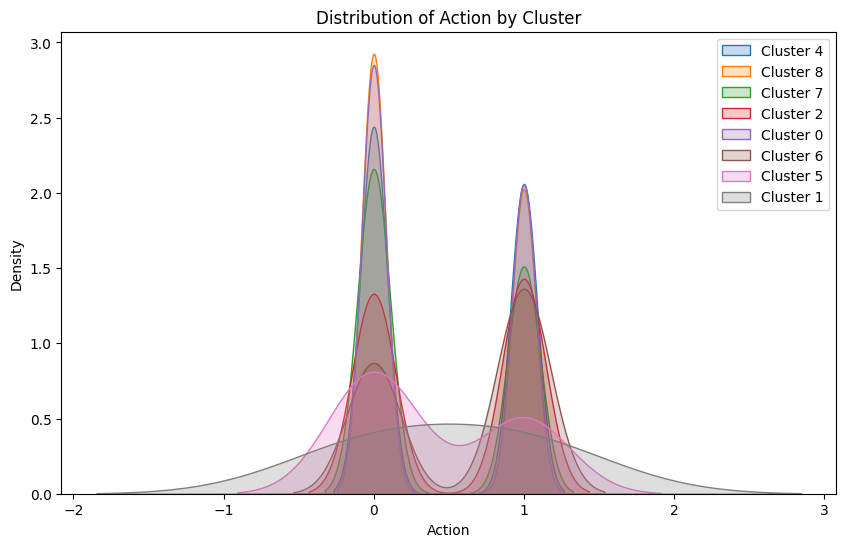

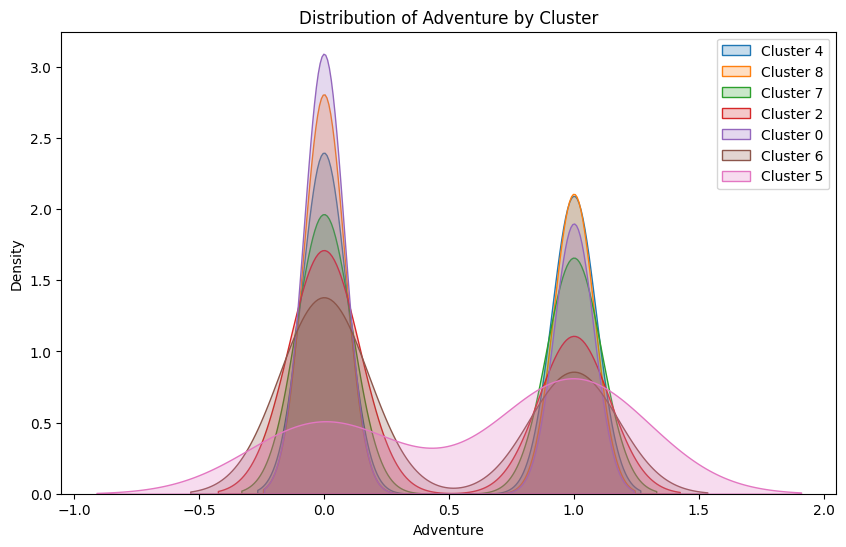

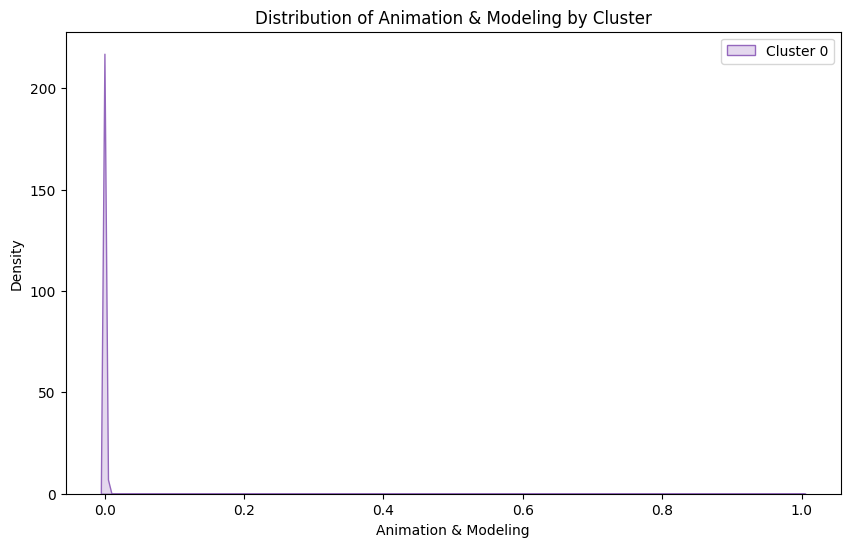

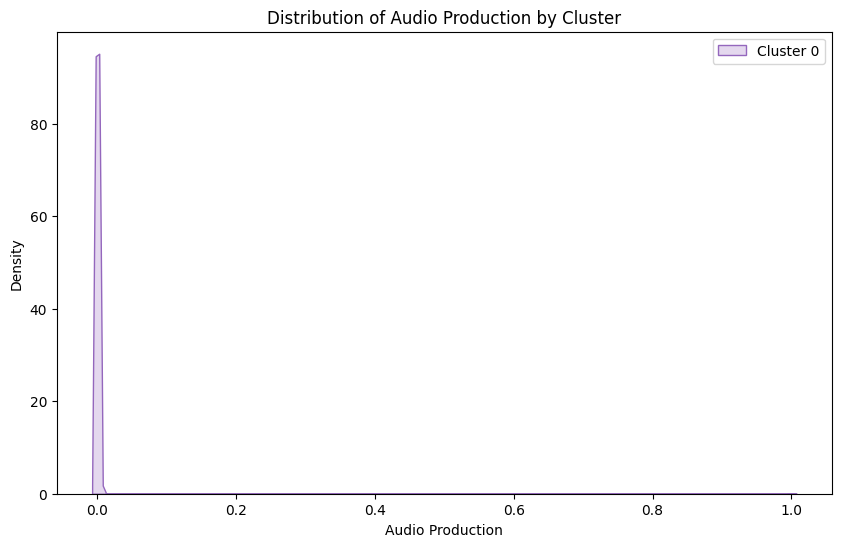

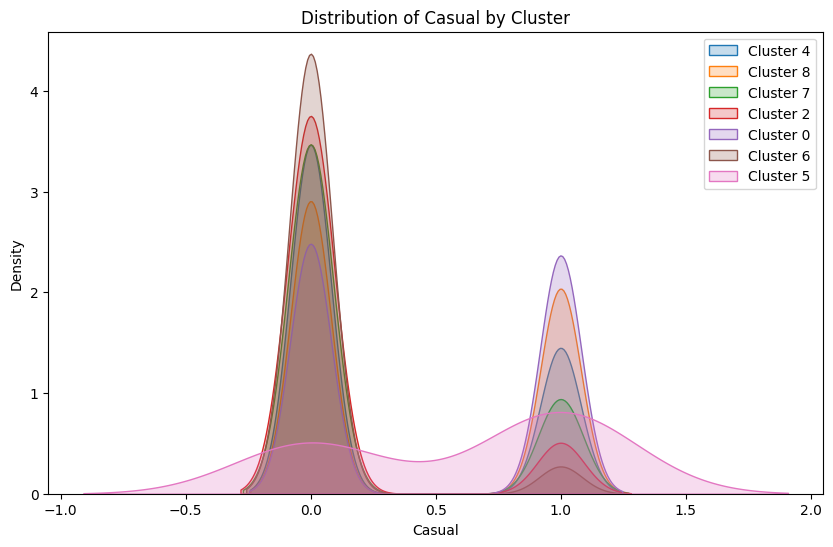

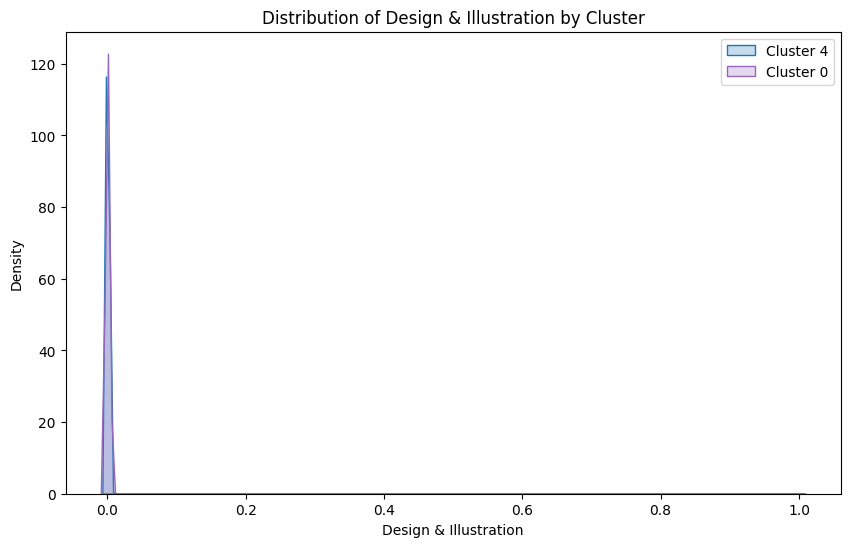

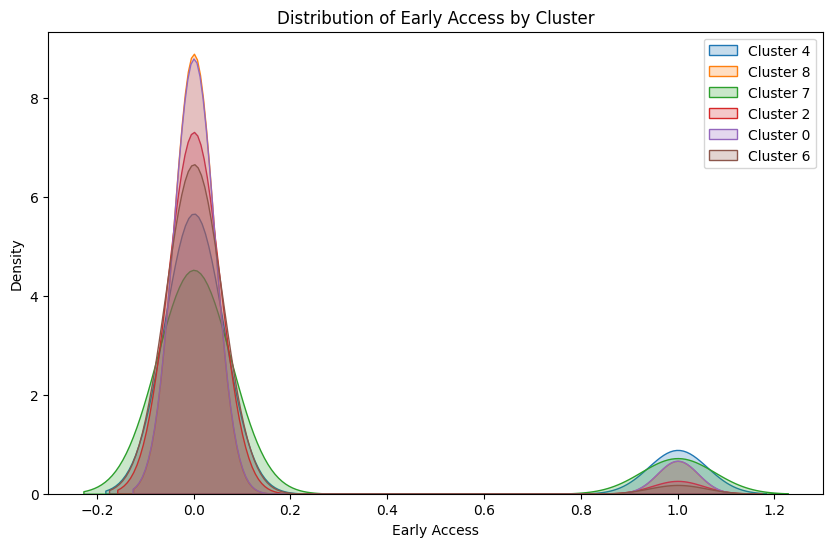

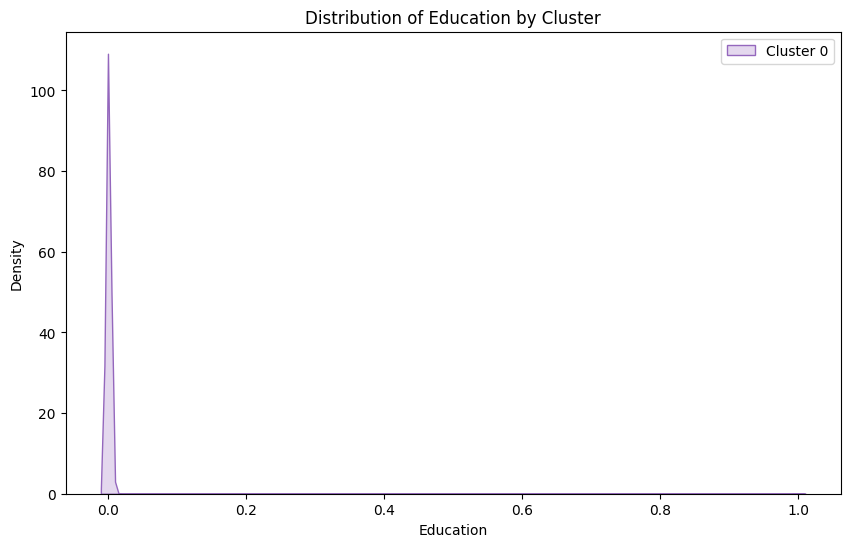

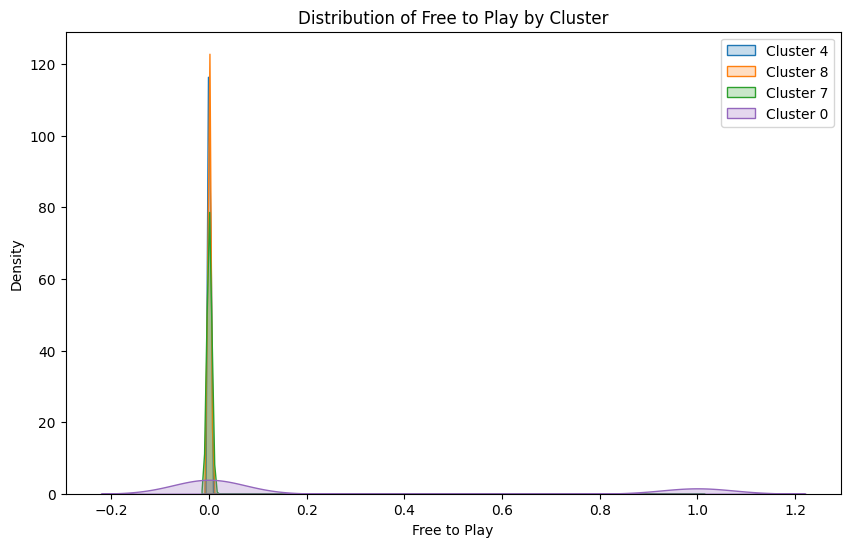

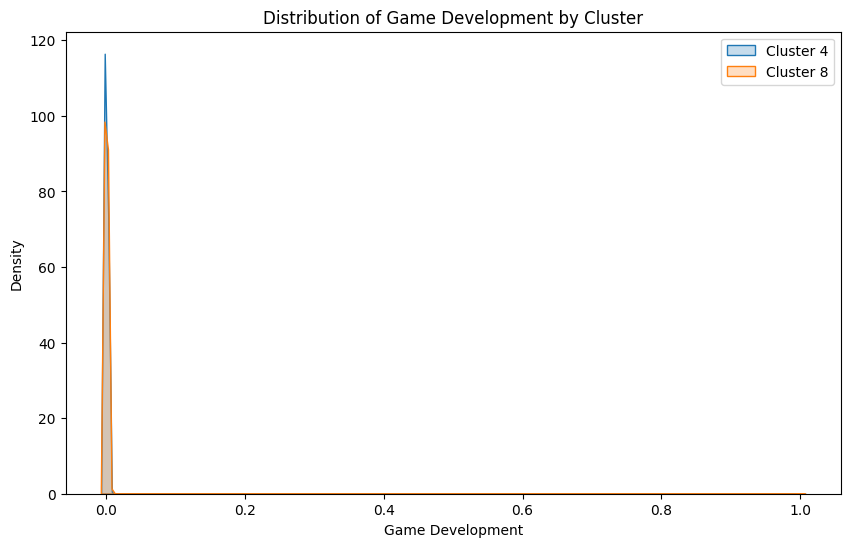

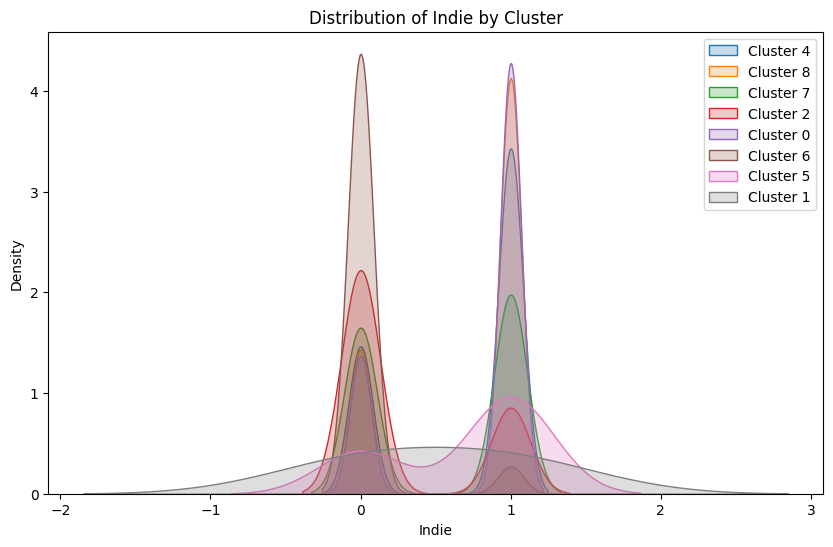

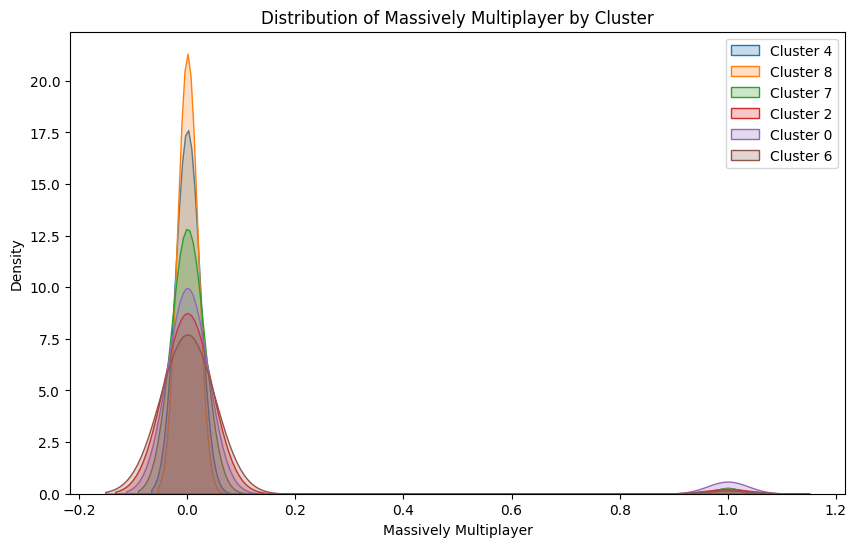

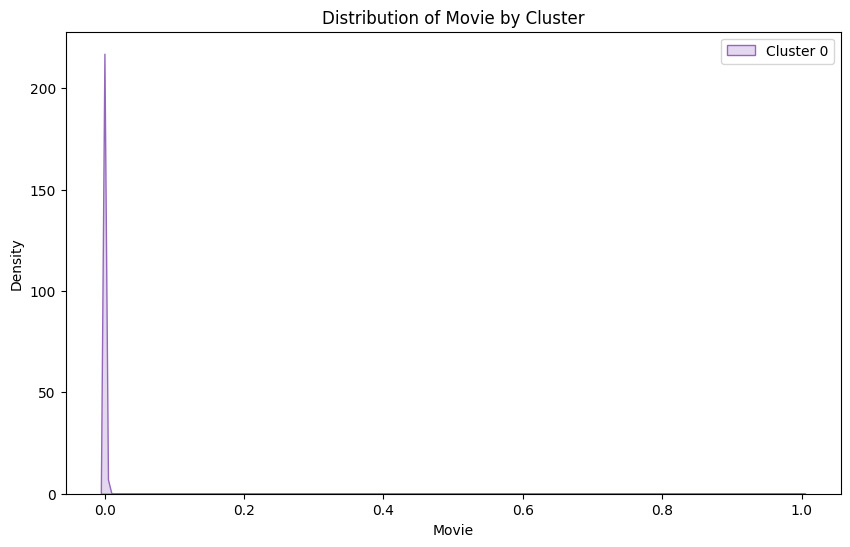

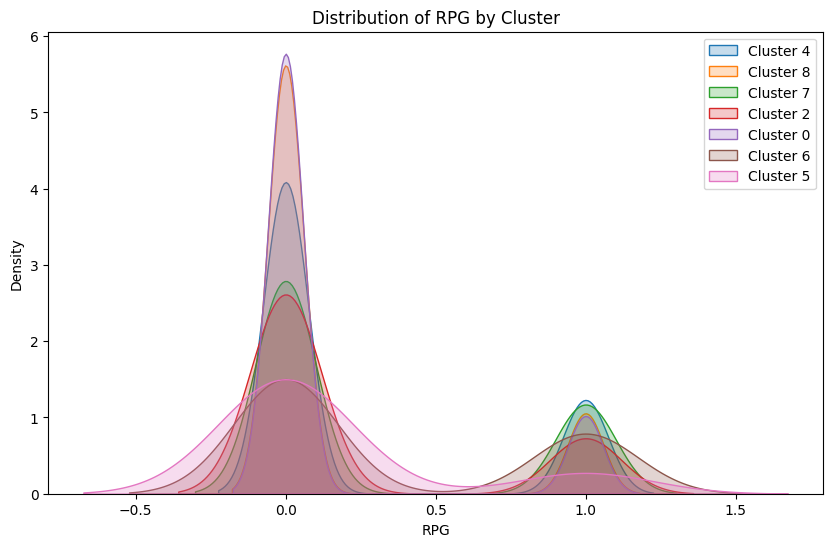

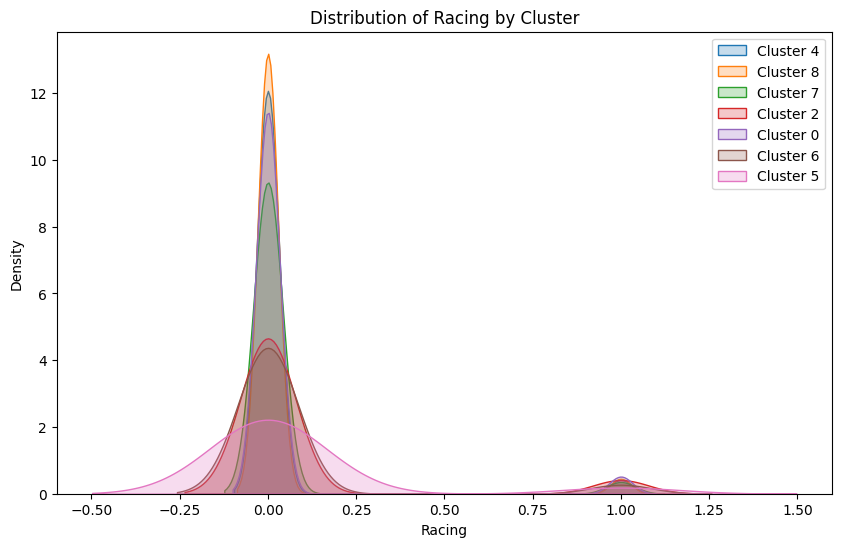

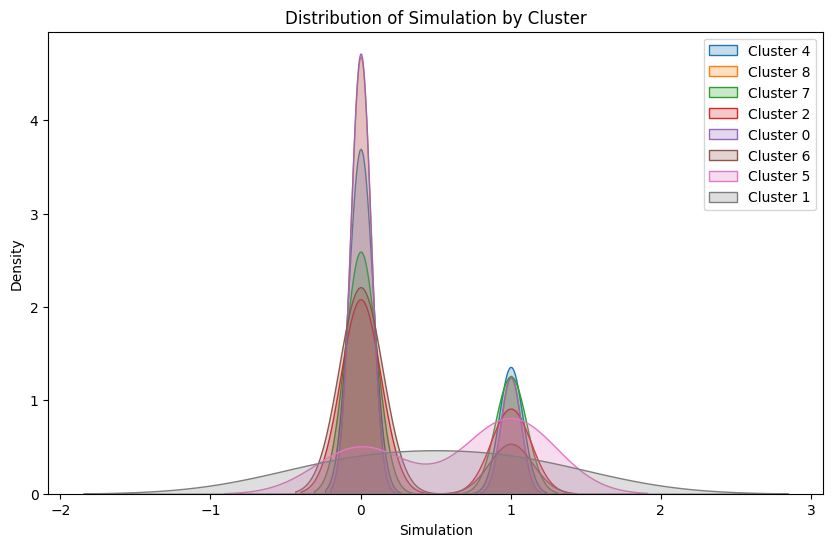

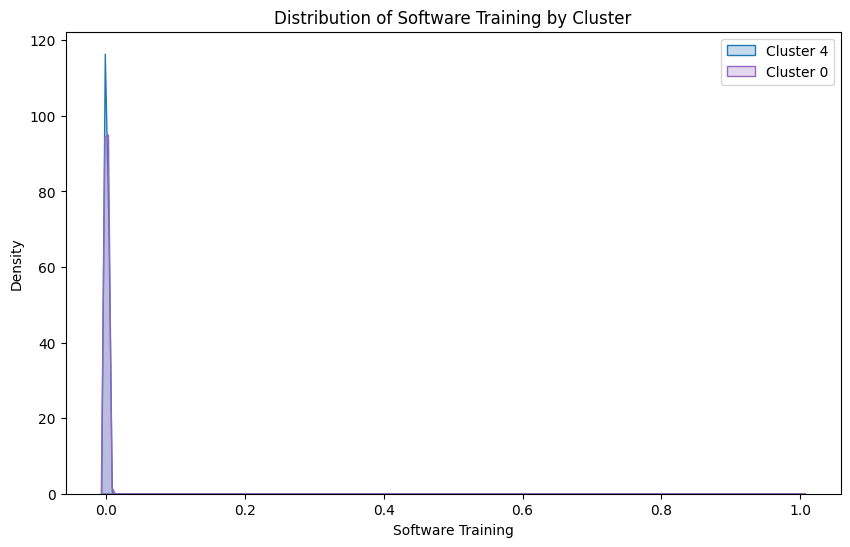

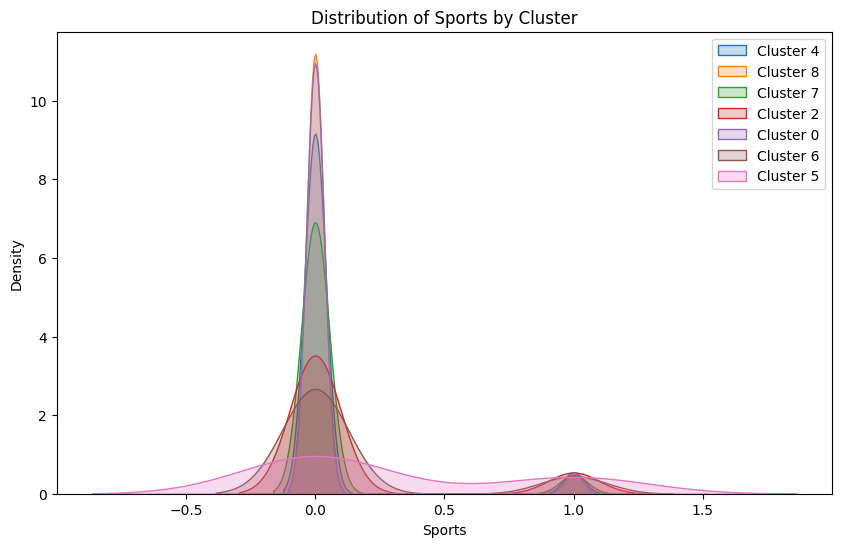

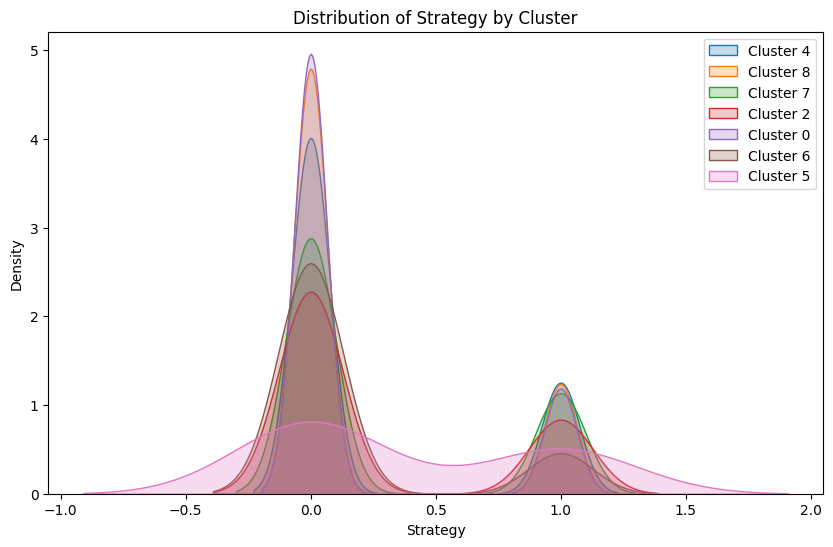

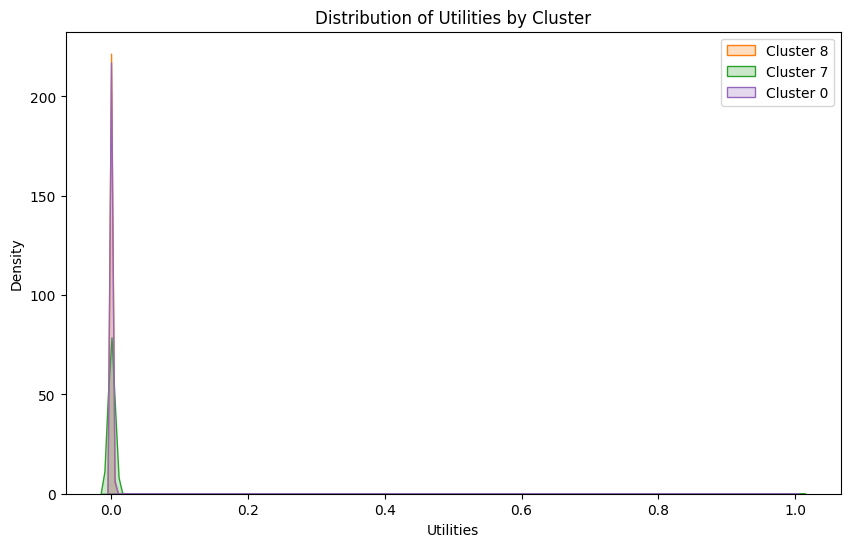

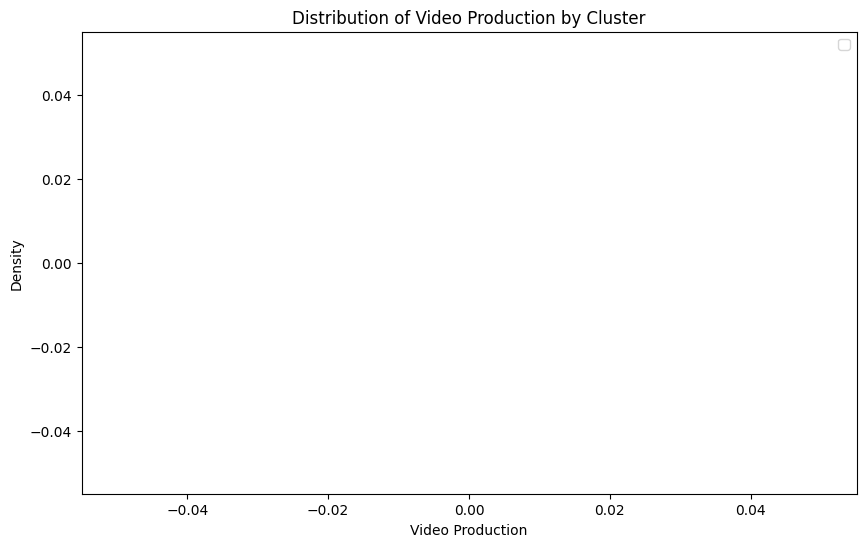

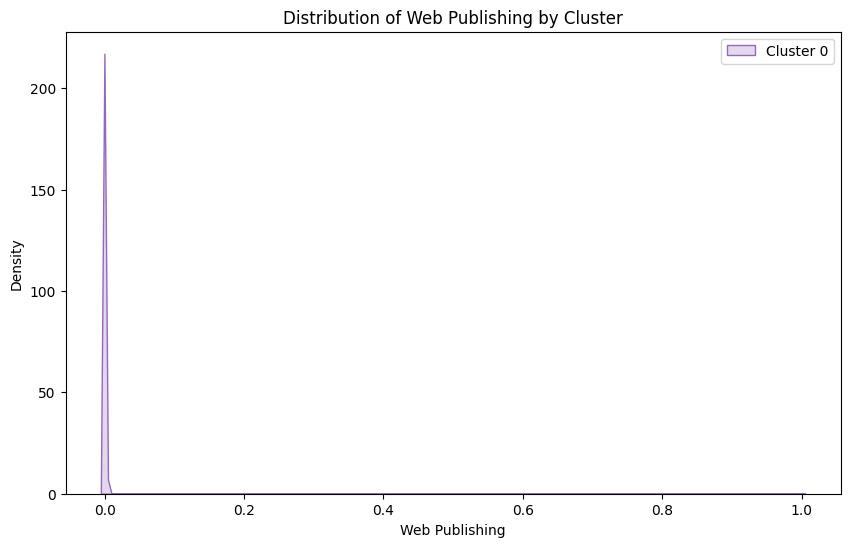

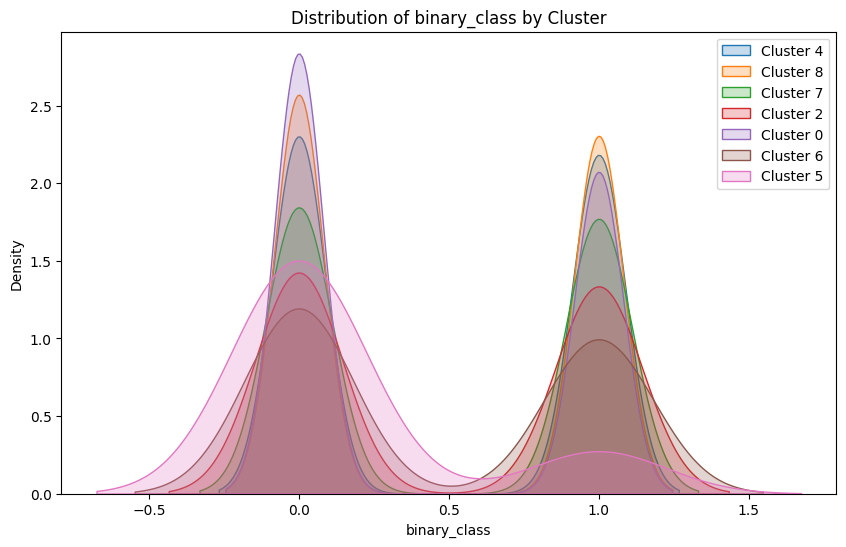

In [ ]:
# distributions
for column in clusters.columns.drop(['cluster', 'pca1', 'pca2']):
    plt.figure(figsize=(10, 6))
    for cluster in clusters['cluster'].unique():
        sns.kdeplot(clusters[clusters['cluster'] == cluster][column], label=f'Cluster {cluster}', fill=True, warn_singular=False)
    plt.title(f'Distribution of {column} by Cluster')
    plt.legend()
    plt.show()